In [3]:
import numpy as np
from keras.datasets import mnist

##**mnist 데이터셋 로드**

28x28 이미지 학습용 6만장 테스트용 1만장

---


정답 레이블 0~9 정수

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


이미지 픽셀 값 0-255 ▶ 0-1 로 정규화

In [5]:
RESHAPED = 784
x_train = x_train.reshape(60000, RESHAPED)
x_test = x_test.reshape(10000, RESHAPED)
x_train = x_train.astype('float64') / 255.0
x_test = x_test.astype('float64') / 255.0
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

정답 레이블 one hot encoding

In [6]:
# print(np.eye(10), end="\n\n")
encoding = np.eye(10)[y_train]
print(encoding[0:3], end="\n\n")
print(len(encoding), end="\n\n") 

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

60000



In [7]:
y_train_ecd = np.eye(10)[y_train]
y_test_ecd = np.eye(10)[y_test]

In [8]:
print(x_train.shape, x_test.shape, '/', y_train.shape, y_test.shape, '/', y_train_ecd.shape, y_test_ecd.shape)

(60000, 784) (10000, 784) / (60000,) (10000,) / (60000, 10) (10000, 10)


batch size 100 설정

In [9]:
x_train = x_train.reshape([600, -1, 784])
x_test = x_test.reshape(100, -1, 784)
y_train_ecd = y_train_ecd.reshape(600, -1, 10)
y_test_ecd = y_test_ecd.reshape(100, -1, 10)
print(x_train.shape, x_test.shape, '/', y_train_ecd.shape, y_test_ecd.shape)

(600, 100, 784) (100, 100, 784) / (600, 100, 10) (100, 100, 10)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

numpy 데이터 torch tensor 형식으로 변경

In [11]:
x_trainT = torch.Tensor(x_train)
x_testT = torch.Tensor(x_test)
y_trainT = torch.Tensor(y_train_ecd)
y_testT = torch.Tensor(y_test_ecd)

fully connected model 정의

In [12]:
class MultilayerPerceptron(nn.Module):
  def __init__(self, in_sz , out_sz, layers=[120, 84]):
    super().__init__()

    self.fc1 = nn.Linear(in_sz,layers[0])
    self.fc2 = nn.Linear(layers[0],layers[1])
    self.fc3 = nn.Linear(layers[1],out_sz)

  def forward(self, X):
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return X

input size 28x28 = 784

---


output size 0~9 one hot encoding = 10

In [13]:
model = MultilayerPerceptron(784, 10)
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

GPU 장치 torch 할당 및 model에 적용

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
epochs = 10
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  model.train()
  for b in range(len(x_trainT)):
    data = x_trainT[b].to(device)
    truth_ = y_trainT[b].to(device)
    y_pred = model(data)    

    loss = criterion(y_pred, truth_)
    # print('loss : ', loss, y_pred.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  with torch.no_grad():
    model.eval()
    for b in range(len(x_testT)):
      data = x_testT[b].to(device)
      truth = y_testT[b].to(device)
      y_val = model(data)
      t1 = torch.argmax(y_val, dim=1)
      t2 = torch.argmax(truth, dim=1)
      tst_corr += (t1 == t2).sum() * 100 / 100.0
      model.train()
        
    loss = criterion(y_val, truth)
    print('test loss :', loss.item())
    print('test acc :', tst_corr.item()/100, '%')

test loss : 0.18213172256946564
test acc : 95.3 %
test loss : 0.15671810507774353
test acc : 96.04 %
test loss : 0.13258115947246552
test acc : 96.52 %
test loss : 0.10803084820508957
test acc : 96.02 %
test loss : 0.14904846251010895
test acc : 96.98 %
test loss : 0.11645124107599258
test acc : 97.15 %
test loss : 0.09001487493515015
test acc : 97.19 %
test loss : 0.2691776156425476
test acc : 96.48 %
test loss : 0.0645529255270958
test acc : 96.54 %
test loss : 0.20358262956142426
test acc : 96.88 %


In [65]:
import matplotlib.pyplot as plt

with torch.no_grad():
    random_sample = np.random.randint(x_test.shape[0])
    model.to('cpu')
    model.eval()
    y_pred = model(torch.Tensor(x_test[random_sample]))
    y_pred2 = np.argmax(y_pred.numpy(), axis=1)
    y = y_test.reshape(100, -1, 1)[random_sample]
    

In [61]:
def display_test(x, y, y_pred):
  plt_r = 5
  plt_c = int(np.round(x.shape[0] / plt_r))

  plt.figure(figsize=(15,5))

  for y_pos in range(plt_r):
    for x_pos in range(plt_c):
      idx = y_pos*plt_c + x_pos
      if idx >= x.shape[0] :
                break
      plt.subplot(plt_r, plt_c, idx+1)

      prt = '[%d, %d]' % (y[idx], y_pred[idx])
      plt.title(prt)
      plt.imshow(x[idx].reshape(28, 28), 'gray')

      ax = plt.gca()
      ax.axes.xaxis.set_visible(False)
      ax.axes.yaxis.set_visible(False)

  plt.show()

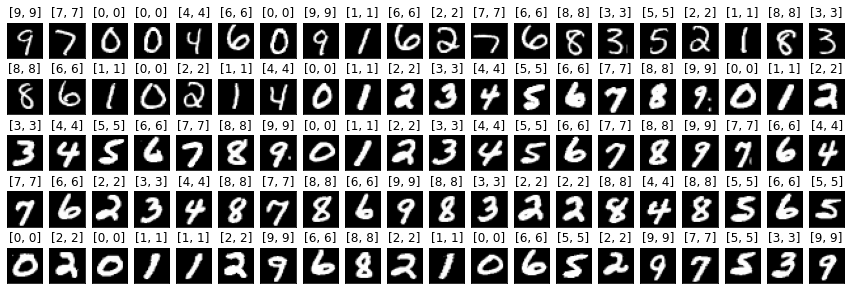

In [66]:
display_test(x_test[random_sample], y, y_pred2)